In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from processing import biosppy_processing, nk_processing, processing_aggregate
from time_domain import time
from frequency_domain import frequency
from nonlinear import nonlinear
import numpy as np
import scipy
from tqdm.notebook import tqdm

pd.set_option('display.float_format', lambda x: f'{x:.2f}') 

## 0. Read Data

In [2]:
sampling_rate = 2000
raw = pd.read_csv('./data/ecg_70.txt', sep = ' ').T
raw

,1,2,3,4,5,6,7,8,9,10,...,239991,239992,239993,239994,239995,239996,239997,239998,239999,240000
id1,0.79,0.79,0.79,0.78,0.78,0.77,0.77,0.76,0.76,0.75,...,1.75,1.69,1.62,1.56,1.49,1.43,1.36,1.30,1.23,1.16
id2,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02
id3,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13
id4,-0.36,-0.36,-0.35,-0.34,-0.34,-0.33,-0.33,-0.32,-0.32,-0.31,...,-0.20,-0.19,-0.19,-0.19,-0.19,-0.19,-0.19,-0.19,-0.19,-0.19
id5,-0.02,-0.02,-0.02,-0.02,-0.02,-0.01,-0.01,-0.01,-0.01,-0.01,...,0.10,0.08,0.06,0.03,0.01,-0.01,-0.03,-0.05,-0.07,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id69,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.09,0.09,0.10,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
id70,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,...,-0.07,-0.09,-0.10,-0.12,-0.13,-0.14,-0.15,-0.16,-0.16,-0.17
id71,-0.55,-0.55,-0.55,-0.55,-0.55,-0.55,-0.55,-0.56,-0.56,-0.56,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
id72,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.02,...,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.08,-0.08


## 1. Time Domain

In [22]:
start = 0
start *= 2000
end = 10
end *= 2000

start_end_dict = {
    '2min' : np.array([[0, 120]])*2000,
    '1min' : np.array([[0, 60], [15, 75], [30, 90], [45, 105], [60, 120]])*2000,
    '30sec' : np.array([[0, 30], [30, 60], [45, 75], [60, 90], [90, 120]])*2000,
    '20sec' : np.array([[0, 20], [25, 45], [50, 70], [75, 95], [100, 120]])*2000,
    '10sec' : np.array([[0, 10], [30, 40], [55, 65], [90, 100], [110, 120]])*2000,
    
}

time_result_dict = dict()


for key, val in tqdm(start_end_dict.items()):
    for start, end in val:
        temp = dict()
        for row in raw.iterrows():
            id = row[0]
            sampling_rate = 2000
            signal = row[1].tolist()[start : end]
            pro = nk_processing(signal, sampling_rate)
            temp[id] = time(pro['rpeaks'], 2000)
        time_result_dict[f'{key}_{start}_{end}'] = temp
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
time_result_dict.keys()

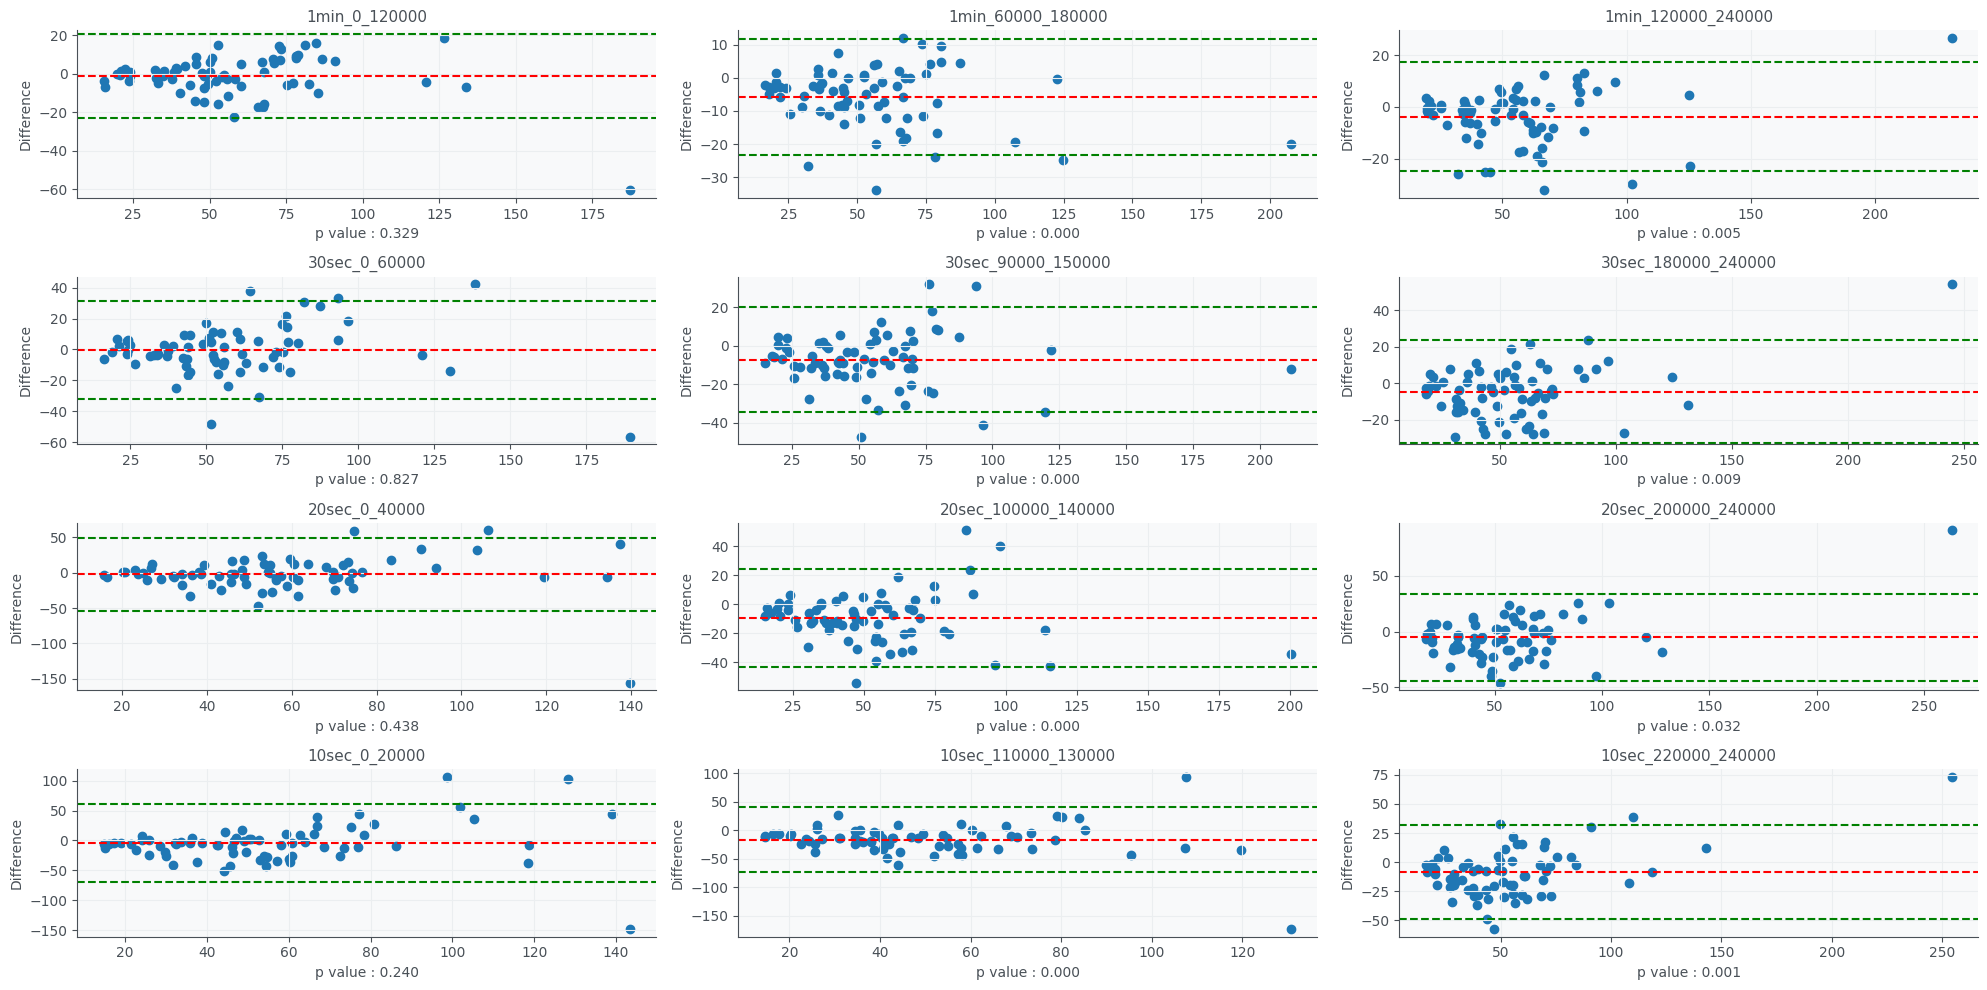

In [5]:
results = pd.DataFrame()
results.index = time_result_dict['2min_0_240000'].keys()
for key, val in time_result_dict.items():
    results[key] = pd.DataFrame(val).T['pyhrv sdnn']

plt.figure(figsize = (20, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
for i, sec in enumerate(['1min_0_120000', '1min_60000_180000', '1min_120000_240000', '30sec_0_60000', '30sec_90000_150000', '30sec_180000_240000', '20sec_0_40000', '20sec_100000_140000', '20sec_200000_240000', '10sec_0_20000', '10sec_110000_130000', '10sec_220000_240000']):
    
    plt.subplot(4,3,i+1)
    method_b = results[sec]
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(sec)
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


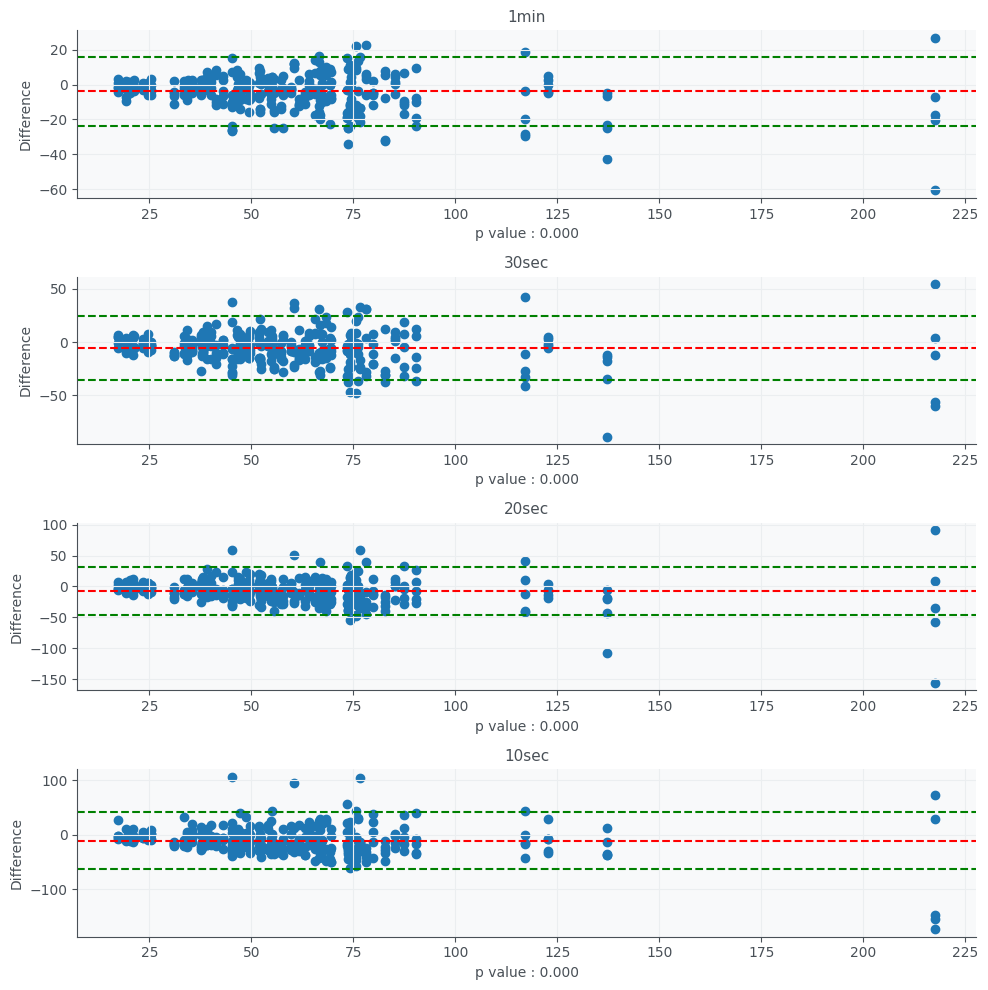

In [7]:
results = pd.DataFrame()
results.index = time_result_dict['2min_0_240000'].keys()
for key, val in time_result_dict.items():
    results[key] = pd.DataFrame(val).T['pyhrv sdnn']





plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


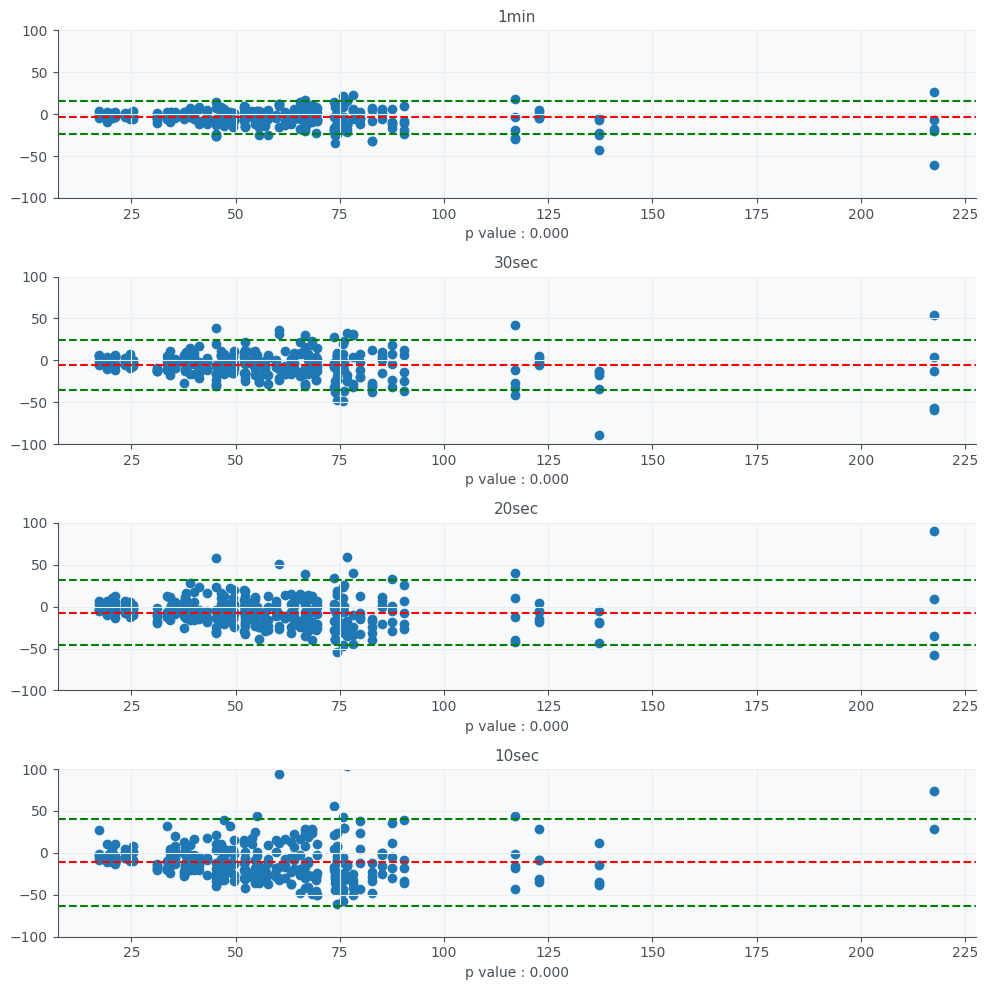

In [26]:
results = pd.DataFrame()
results.index = time_result_dict['2min_0_240000'].keys()
for key, val in time_result_dict.items():
    results[key] = pd.DataFrame(val).T['pyhrv sdnn']





plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = method_a
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylim([-100, 100])
plt.tight_layout()


In [ ]:
results = pd.DataFrame()
results.index = time_result_dict['2min_0_240000'].keys()
for key, val in time_result_dict.items():
    results[key] = pd.DataFrame(val).T['pyhrv rmssd']


plt.figure(figsize = (20, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
for i, sec in enumerate(['1min_0_120000', '1min_60000_180000', '1min_120000_240000', '30sec_0_60000', '30sec_90000_150000', '30sec_180000_240000', '20sec_0_40000', '20sec_100000_140000', '20sec_200000_240000', '10sec_0_20000', '10sec_110000_130000', '10sec_220000_240000']):
    
    plt.subplot(4,3,i+1)
    method_b = results[sec]
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(sec)
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


In [ ]:
results = pd.DataFrame()
results.index = time_result_dict['2min_0_240000'].keys()
for key, val in time_result_dict.items():
    results[key] = pd.DataFrame(val).T['pyhrv rmssd']

plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


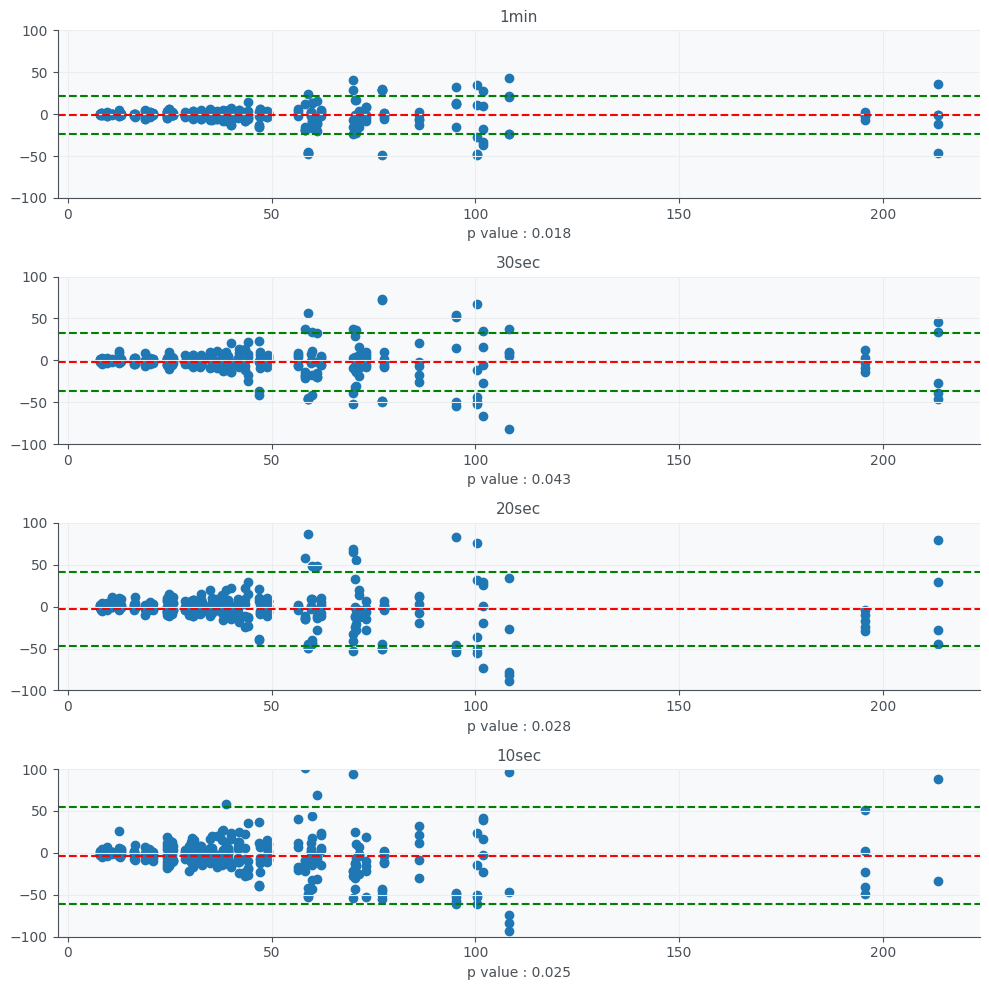

In [27]:
results = pd.DataFrame()
results.index = time_result_dict['2min_0_240000'].keys()
for key, val in time_result_dict.items():
    results[key] = pd.DataFrame(val).T['pyhrv rmssd']

plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = method_a
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylim([-100, 100])

plt.tight_layout()


## 2. Frequency Domain

In [12]:

frequency_result_dict = dict()



for key, val in tqdm(start_end_dict.items()):
    print('-'*100)
    for start, end in val:
        temp = dict()
        for row in raw.iterrows():
            id = row[0]
            sampling_rate = 2000
            signal = row[1].tolist()[start : end]
            pro = nk_processing(signal, sampling_rate)
            temp[id] = frequency(pro['rpeaks'], 2000)['pyhrv welch']['fft_ratio']
        frequency_result_dict[f'{key}_{start}_{end}'] = temp




  0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [ ]:
results = pd.DataFrame()
results.index = frequency_result_dict['2min_0_240000'].keys()
for key, val in frequency_result_dict.items():
    results[key] = val

plt.figure(figsize = (20, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
for i, sec in enumerate(['1min_0_120000', '1min_60000_180000', '1min_120000_240000', '30sec_0_60000', '30sec_90000_150000', '30sec_180000_240000', '20sec_0_40000', '20sec_100000_140000', '20sec_200000_240000', '10sec_0_20000', '10sec_110000_130000', '10sec_220000_240000']):
    
    plt.subplot(4,3,i+1)
    method_b = results[sec]
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(sec)
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


In [ ]:
results = pd.DataFrame()
results.index = frequency_result_dict['2min_0_240000'].keys()
for key, val in frequency_result_dict.items():
    results[key] = val

plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


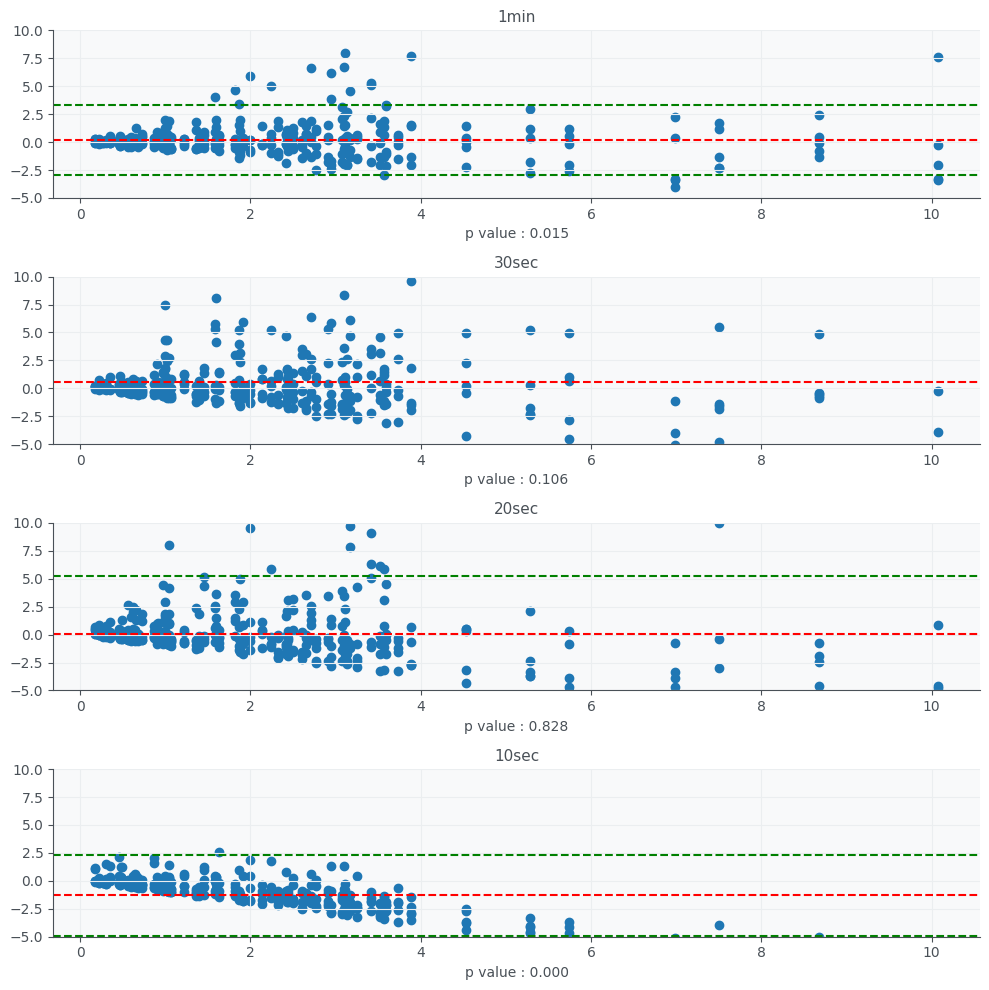

In [16]:
results = pd.DataFrame()
results.index = frequency_result_dict['2min_0_240000'].keys()
for key, val in frequency_result_dict.items():
    results[key] = val

plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = method_a
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylim([-5, 10])
plt.tight_layout()


## 3. Nonlienar

In [17]:
from nonlinear import pyhrv_nonlinear


nonlinear_result_dict = dict()



for key, val in tqdm(start_end_dict.items()):

    for start, end in val:
        temp = dict()
        for row in raw.iterrows():
            id = row[0]
            sampling_rate = 2000
            signal = row[1].tolist()[start : end]
            pro = nk_processing(signal, sampling_rate)
            temp[id] = pyhrv_nonlinear(pro['rpeaks'], 2000)['sd1/sd2']
        nonlinear_result_dict[f'{key}_{start}_{end}'] = temp




  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
results = pd.DataFrame()
results.index = nonlinear_result_dict['2min_0_240000'].keys()
for key, val in nonlinear_result_dict.items():
    results[key] = val

plt.figure(figsize = (20, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
for i, sec in enumerate(['1min_0_120000', '1min_60000_180000', '1min_120000_240000', '30sec_0_60000', '30sec_90000_150000', '30sec_180000_240000', '20sec_0_40000', '20sec_100000_140000', '20sec_200000_240000', '10sec_0_20000', '10sec_110000_130000', '10sec_220000_240000']):
    
    plt.subplot(4,3,i+1)
    method_b = results[sec]
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(sec)
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


In [ ]:
results = pd.DataFrame()
results.index = nonlinear_result_dict['2min_0_240000'].keys()
for key, val in nonlinear_result_dict.items():
    results[key] = val

plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = (method_a + method_b) / 2
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylabel('Difference')
plt.tight_layout()


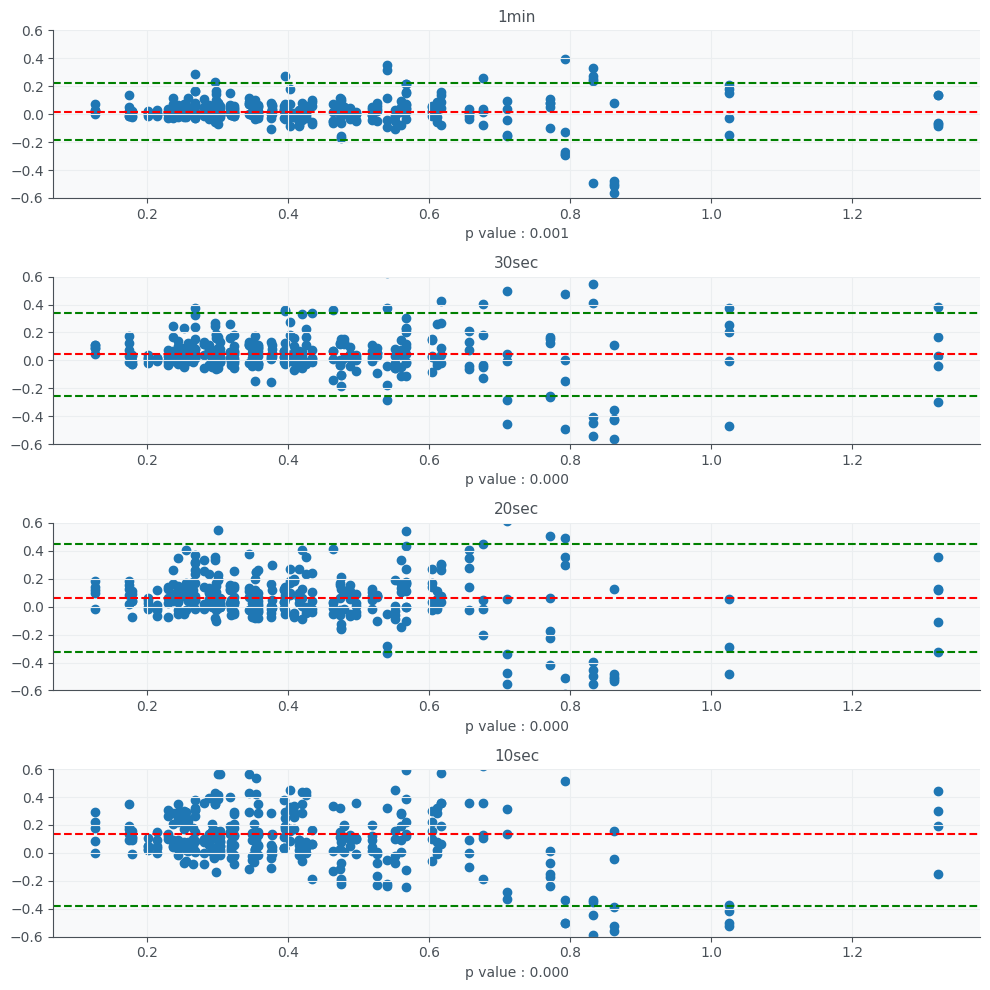

In [21]:
results = pd.DataFrame()
results.index = nonlinear_result_dict['2min_0_240000'].keys()
for key, val in nonlinear_result_dict.items():
    results[key] = val

plt.figure(figsize = (10, 10))
# Sample data: measurements from two methods A and B
method_a = results['2min_0_240000']
method_a = method_a.to_list()*5
for i, sec in enumerate([
    ['1min_0_120000', '1min_30000_150000', '1min_60000_180000', '1min_90000_210000', '1min_120000_240000'], 
    ['30sec_0_60000', '30sec_60000_120000', '30sec_90000_150000', '30sec_120000_180000', '30sec_180000_240000'],
    ['20sec_0_40000', '20sec_50000_90000', '20sec_100000_140000', '20sec_150000_190000', '20sec_200000_240000'],
    ['10sec_0_20000', '10sec_60000_80000', '10sec_110000_130000', '10sec_180000_200000', '10sec_220000_240000']
    ]):
    method_b = list()
    for s in sec:
         method_b += results[s].to_list()
    
    plt.subplot(4,1,i+1)
    method_a = np.array(method_a)
    method_b = np.array(method_b)
    _, p_value = scipy.stats.ttest_rel(method_a, method_b)

    # Calculate the average and the difference between the two methods
    average = method_a
    difference = method_b - method_a

    # Calculate the mean and standard deviation of the differences
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)

    # Plotting the Bland-Altman plot
    plt.scatter(average, difference)  # Differences vs averages
    plt.axhline(mean_difference, color='red', linestyle='--')  # Mean difference
    plt.axhline(mean_difference + 1.96 * std_difference, color='green', linestyle='--')  # Upper limit of agreement
    plt.axhline(mean_difference - 1.96 * std_difference, color='green', linestyle='--')  # Lower limit of agreement

    plt.title(s.split('_')[0])
    plt.xlabel(f'p value : {p_value:.3f}')
    plt.ylim([-0.6, 0.6])
plt.tight_layout()
